<a href="https://colab.research.google.com/github/M-Shreya/Image_Segmentation/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount your Google Drive (if you haven't already)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install -q pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.8 MB/s eta 0:00:00


In [ ]:
!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.4 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading and preparing the MRI slice...
✅ Data is loaded and ready in the 'mri_slice_float' variable.


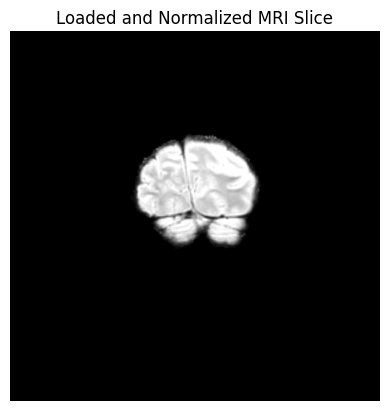

In [ ]:
# ---------------- Step 1: Imports and Helper Functions ------------------
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import morphological_geodesic_active_contour, chan_vese
from skimage.filters import gaussian

def load_scan(path):
    """Loads and sorts DICOM slices."""
    slices = []
    for f in os.listdir(path):
        if f.endswith('.dcm'):
            try:
                ds = pydicom.dcmread(os.path.join(path, f))
                slices.append(ds)
            except Exception as e:
                print(f"Skipping {f}: {e}")
    try:
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except Exception:
        slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

def get_pixels_hu(slices):
    """Converts DICOM slices to a 3D numpy array."""
    image = np.stack([s.pixel_array for s in slices]).astype(np.int16)
    for i in range(len(slices)):
        intercept = getattr(slices[i], 'RescaleIntercept', 0)
        slope = getattr(slices[i], 'RescaleSlope', 1)
        image[i] = image[i] * slope + intercept
    return image

def normalize_percentile(img, lower=1, upper=99):
    """Normalizes an image using percentile-based contrast stretching."""
    p1 = np.percentile(img, lower)
    p99 = np.percentile(img, upper)
    if p99 == p1:
        return np.zeros_like(img, dtype=np.float32)
    img = np.clip(img, p1, p99)
    return (img - p1) / (p99 - p1)

def create_initial_contour(image, center_y, center_x, radius):
    """Creates a circular level set for the algorithms."""
    h, w = image.shape
    Y, X = np.ogrid[:h, :w]
    return (X - center_x)**2 + (Y - center_y)**2 - radius**2

# ---------------- Step 2: Load and Prepare the Image ------------------

DATA_PATH = '/content/drive/MyDrive/Brain_Tumor/train/00033/FLAIR/'

print("Loading and preparing the MRI slice...")
slices = load_scan(DATA_PATH)
volume = get_pixels_hu(slices)
valid_slices = [i for i in range(volume.shape[0]) if np.max(volume[i]) > 0]
if not valid_slices:
    raise ValueError("All slices are empty!")
volume = volume[valid_slices]
slice_index = len(volume) // 2
mri_slice = volume[slice_index]

# Normalize the final slice
mri_slice_float = normalize_percentile(mri_slice)

print("✅ Data is loaded and ready in the 'mri_slice_float' variable.")


plt.imshow(mri_slice_float, cmap='gray')
plt.title("Loaded and Normalized MRI Slice")
plt.axis('off')
plt.show()

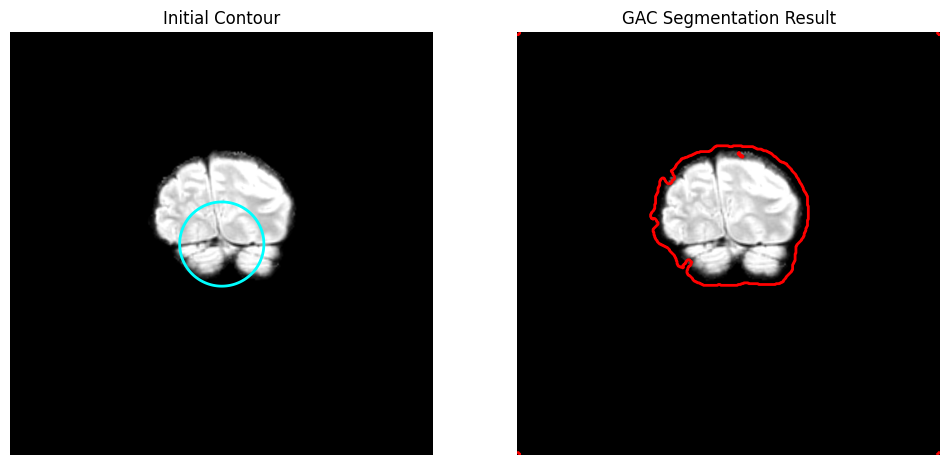

In [ ]:
#-------------- GAC Model ------------

# Define initial circular contour
h, w = mri_slice_float.shape
center_x, center_y = w // 2, h // 2
radius = int(min(h, w) * 0.10)
initial_level_set = create_initial_contour(mri_slice_float, center_y, center_y, radius)

# Apply Geodesic Active Contour (GAC)
smoothed_image = gaussian(mri_slice_float, sigma=1)

gac_result = morphological_geodesic_active_contour(
    smoothed_image,
    num_iter=400,
    init_level_set=initial_level_set,
    smoothing=1,
    balloon=-1.5,
    threshold=0.5
)

# Visualize the GAC result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(mri_slice_float, cmap='gray')
ax1.contour(initial_level_set, [0], colors='cyan', linewidths=2)
ax1.set_title("Initial Contour")
ax1.axis('off')
ax2.imshow(mri_slice_float, cmap='gray')
ax2.contour(gac_result, [0], colors='red', linewidths=2)
ax2.set_title("GAC Segmentation Result")
ax2.axis('off')
plt.show()

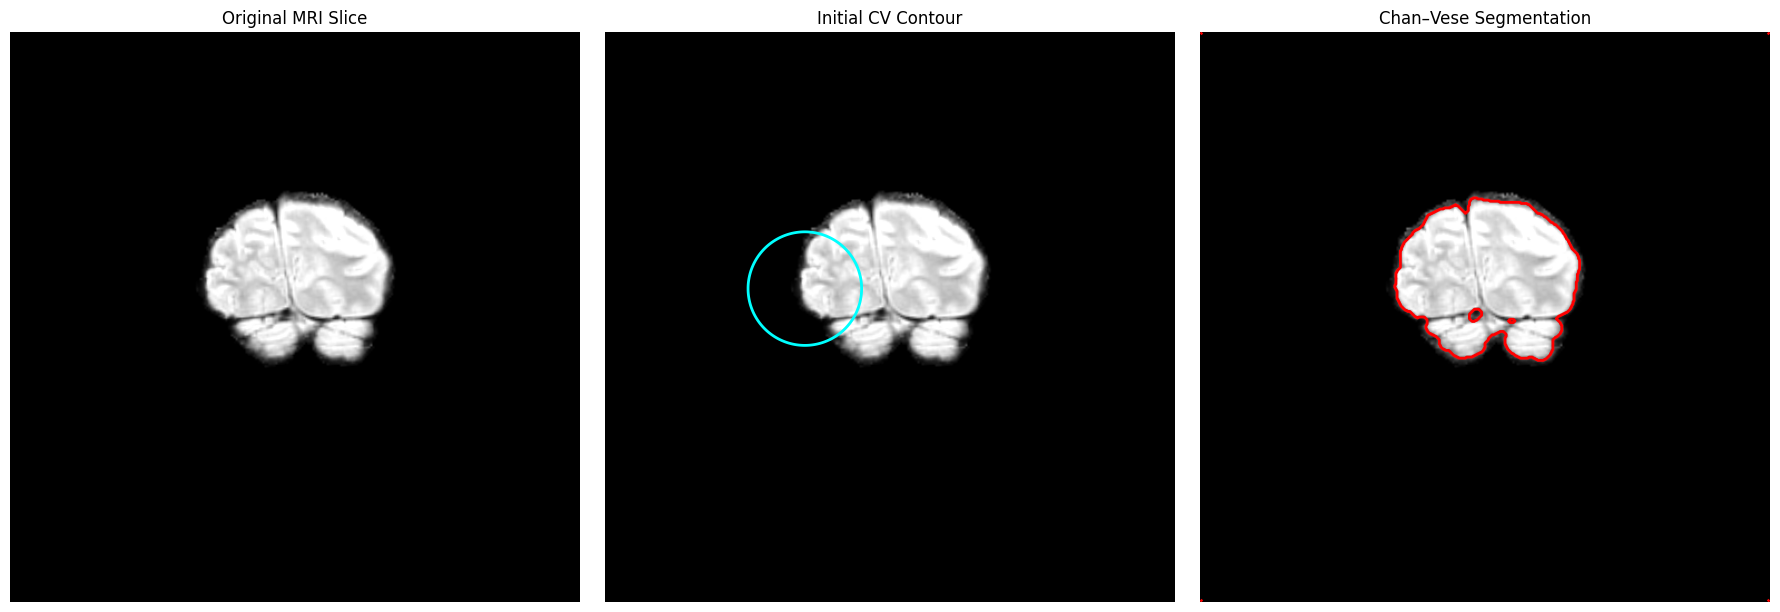

In [ ]:
# ---------------- Chan–Vese Region-Based Segmentation ----------------

from skimage.segmentation import morphological_chan_vese, checkerboard_level_set

img = mri_slice_float

# Create initial level set
center_x, center_y = int(w * 0.35), int(h * 0.45)
radius = int(min(h, w) * 0.10)
initial_cv = create_initial_contour(img, center_y, center_x, radius)


# Apply Chan–Vese model
cv_result = morphological_chan_vese(
    img,
    num_iter=300,
    init_level_set=initial_cv,
    smoothing=2,
    lambda1=1,
    lambda2=1
)

# ---------------- Visualization ----------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['Original MRI Slice', 'Initial CV Contour', 'Chan–Vese Segmentation']
images = [img, img, img]
contours = [None, initial_cv, cv_result]
colors = [None, 'cyan', 'red']

for ax, image, title, cont, color in zip(axes, images, titles, contours, colors):
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    if cont is not None:
        ax.contour(cont, [0.5], colors=color, linewidths=2)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


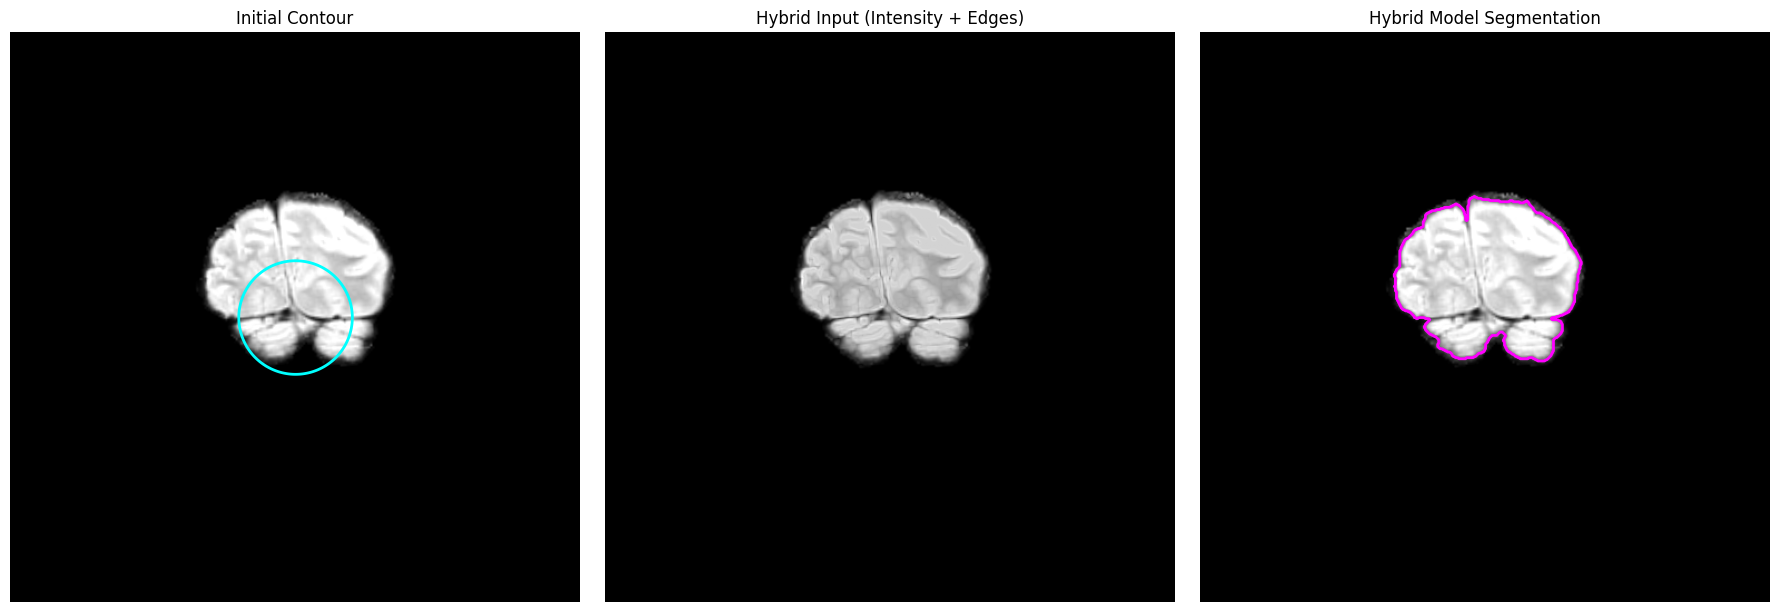

In [ ]:
#-------------- Hybrid Model ---------------------

from skimage.filters import sobel
from skimage.segmentation import chan_vese


gradient_image = sobel(mri_slice_float)
gradient_image = (gradient_image - gradient_image.min()) / (gradient_image.max() - gradient_image.min())

#Create the hybrid input image
hybrid_input = 0.7 * mri_slice_float + 0.3 * gradient_image

#Define the initial contour
h, w = mri_slice_float.shape
center_x, center_y = w // 2, h // 2
radius = int(min(h, w) * 0.10)
initial_level_set = create_initial_contour(mri_slice_float, center_y, center_y, radius)

# Run the chan_vese model on this new hybrid_input
hybrid_segmentation = morphological_chan_vese(
    hybrid_input,
    num_iter=300,
    smoothing=1,
    lambda1=1,
    lambda2=1,
    init_level_set=initial_level_set
)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax = axes.flatten()


ax[0].imshow(mri_slice_float, cmap='gray')
ax[0].contour(initial_level_set, [0], colors='cyan', linewidths=2)
ax[0].set_title("Initial Contour")
ax[0].axis('off')


ax[1].imshow(hybrid_input, cmap='gray')
ax[1].set_title("Hybrid Input (Intensity + Edges)")
ax[1].axis('off')


ax[2].imshow(mri_slice_float, cmap='gray')
ax[2].contour(hybrid_segmentation, [0], colors='magenta', linewidths=2)
ax[2].set_title("Hybrid Model Segmentation")
ax[2].axis('off')

plt.tight_layout()
plt.show()